# DAA M05 Classification and neural networks
## Case Study 2

### Purpose:
This case study involves building neural networks to recognise handwritten digits from zero to nine. The case study also compares the performance of the neural networks built to the performance of a gradient boosting machine (GBM) built to solve the same problem.

### References:
The dataset used in this case study is a famous Modified National Institute of Standards and Technology (MNIST) dataset of handwritten images (http://yann.lecun.com/exdb/mnist/). The MNIST dataset is popular for use in benchmarking classification algorithms.

The dataset has 42,000 observations, each representing a greyscale image of a hand-drawn digit from zero to nine. Each image is 28 pixels in height and 28 pixels in width, making a total of 784 pixels (28x28). Each pixel has a single pixel value associated with it, from 0 to 255, indicating the lightness or darkness of that pixel. Higher pixel values represent darker pixels. The dataset represents these images as 784 features, with each feature representing a different pixel in the image.

The dataset also contains one response ('label') that takes integer values from zero to nine, indicatating the digit drawn in each image.

## Packages
This section imports the packages that will be required for this exercise/case study.

We'll use:


*   pandas for data management
*   numpy for mathematical operations
*   Support functions from matplotlib, sklearns, seaborn packages
*   keras, from the tensorflow package, for fitting the neural networks

In [61]:
import pandas as pd # For data management.
import numpy as np # For mathematical operations.

# Matplotlib and Seaborn are used for plotting.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Various scikit-learn functions to help with modelling and diagnostics.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


# Keras, from the Tensorflow package, is used for fitting the neural networks.
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import os
from google.colab import files

## Functions

This section defines functions that will be used for this exercise/case study.

In [5]:
# Define a function to split the data into train, validation, and test sets.
# This function uses the train_test_split function from the sklearn package
# to do the actual data splitting.

def create_data_splits(dataset, response_col):
  # Split data into train/test (80%, 20%).
  train_full, test = train_test_split(dataset, test_size = 0.2, random_state = 123)

  # Create a validation set from the training data (20%).
  train, validation = train_test_split(train_full, test_size = 0.2, random_state = 234)

  # Create train and validation model matrices and response vectors.
  # For the response vector, convert Churn Yes/No to 1/0

  feature_cols = [i for i in dataset.columns if i not in response_col]

  train_x = train.drop(labels=response_col, axis=1)
  train_y = train[response_col]
  train_y.index = range(len(train_y))

  validation_x = validation.drop(labels=response_col, axis=1)
  validation_y = validation[response_col]
  validation_y.index = range(len(validation_y))

  test_x = test.drop(labels=response_col, axis=1)
  test_y = test[response_col]
  test_y.index = range(len(test_y))

  return train_x, train_y, validation_x, validation_y, test_x, test_y

In [6]:
# Define a function to generate a confusion matrix to observe a model's results.
def plot_confusion_matrix(cm, classes,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots a confusion matrix.
    Normalisation of the matrix can be applied by setting `normalise=True`.
    Normalisation ensures that the sum of each row in the confusion matrix is 1.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True response')
    plt.xlabel('Predicted response')

## Data
This section:
- imports the data that will be used in the modelling;
- explores the data; and
- prepares the data for modelling.

### Import data

The code below uploads the csv file to google colab, and then reads it into a pandas data frame.

Note that the MNIST dataset is large (75MB) hence it is slow to upload using the 'files.upload()' method.

An alternative, faster method to upload the dataset is to first save it
to Google Drive (https://drive.google.com/drive/my-drive) in a folder called 'DAA datasets' and then upload the file into Colab directly from Google Drive.

The Google Drive method is used below. The 'files.upload()' method is also included (commented out with ##) in case you would prefer to avoid using Google Drive.

In [ ]:
# Mount your Google Drive.

# If you are using the suggested method of uploading directly from Google
# Drive, you first need to run the code below to mount your Google Drive
# folder to Colab so that it can be accessed in Colab.
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
  # After running this code, you should follow the steps shown in the
  # output box below:
  #    1. click on the link to Google Drive;
  #    2. login to Google Drive;
  #    3. copy the authorization code provided;
  #    4. paste the authorization code into the box below.

In [7]:
# Specify the Google Drive folder that your datasets are saved in.
infolder = '/home/analytics-user/personal/daa_2021s2/Exercises/05 Classification/Datasets/'

In [8]:
# Import the dataset from Google Drive.

# Specify the filename from your Google Drive.
file = 'DAA_M05_CS2_data.csv'

# Read in the data from your Google Drive folder.
dataset = pd.read_csv (infolder+file)

# Alternative (slower) method:
# files.upload()
  # When prompted, select the DAA_M05_CS2_data.csv dataset to upload.
  # Note that this may take some time to upload as the file is large.
# dataset = pd.read_csv('/content/DAA_M05_CS2_data.csv', header = 0)

In [9]:
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Explore data (EDA)
Prior to commencing any modelling, the code below observes:

- the features in the dataset and their types;
- the count of the number of observations for each response class.

Graphical observations of the images will be made later in the notebook once the data has been pre-processed.

In [10]:
# Check the types of each feature and the response variable ('label').
dataset.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


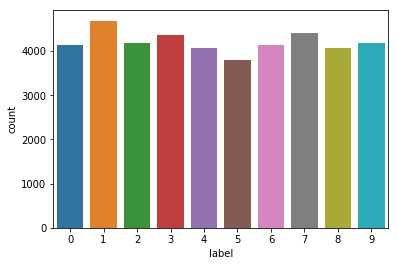

In [11]:
# Extract the counts for each response class (digit) and build a barplot of these
# counts for each of interpretation.
sns.countplot(x='label',data=dataset)
print(dataset['label'].value_counts())

### Prepare data
The dataset will be pre-processed so that neural networks can be built with the data.


In [12]:
## Split the dataset into a train, validation, and test set. 
train_x, train_y, validation_x, validation_y, test_x, test_y \
= create_data_splits(dataset, 'label')

In [13]:
# Rescale the features from being in the range [0,255] to [0:1].
train_x = train_x/255.0
validation_x = validation_x/255.0
test_x = test_x/255.0

Reshaping the data converts each row (784 columns) into a 28x28x1 matrix. 

In [20]:
# Reshape the features for each observation from being a vector of size 784
# to being a matrix of size 28x28.
# This is required for building the convolutional neural network (CNN) below.
train_cnn_x = train_x.values.reshape(-1, 28, 28, 1)
validation_cnn_x = validation_x.values.reshape(-1, 28, 28, 1)
test_cnn_x = test_x.values.reshape(-1, 28, 28, 1)

### View observations
The code below visualises an observation (hand-written digit) from each of the response classes.

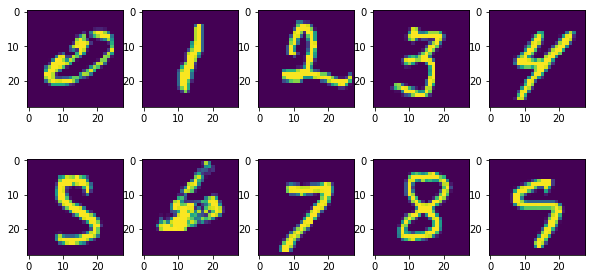

In [52]:
# Visualise an example from each of the response classes
# (the digits from 0 to 9).
fig = plt.figure(figsize=(10,5))
rows = 2
columns = 5
for i in range(0, 10):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_cnn_x[train_y[train_y == i].index[0]][:,:,0])
plt.show()


In [53]:
# Encode the response from a continuous (integer) to a categorical variable.
train_y = to_categorical(train_y, num_classes=10)
validation_y = to_categorical(validation_y, num_classes=10)
test_y = to_categorical(test_y, num_classes=10)

## Modelling
This section:
- fits a model;
- evaluates the fitted model;
- improves the model; and
- selects a final model.

### Fit a 'vanilla' neural network (NN 1)

The code below uses Keras to construct a neural network with:
- two hidden layers, each with 16 neurons and the ReLU activation function; and
- one output layer with 10 neurons (representing each of the digits from zero to nine) and the softmax activation function.



In [64]:
# Specify the model's architecture.
nn_model = Sequential()
nn_model.add(Dense(16, input_dim= 784, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
nn_model.add(Dense(10, activation='softmax'))

# Compile the model.
opt = SGD(learning_rate=0.2, momentum=0.0)
  # This specifies that regular stochastic gradient descent (SGD) should be
  # used with a learning rate of 0.2.
  # Momentum = 0 specifies that the regular SGD algorithm should be used
  # 'without momentum'.
  # SGD with momentum is a variant on regular SGD that uses an
  # exponential moving average of current and past gradients rather than just
  # the gradient for the current iteration.
nn_model.compile(
    loss='categorical_crossentropy', 
      # The 'categorical_crossentropy' loss function is useful
      # for an integer response variable.
    optimizer =  opt,

    metrics=['accuracy'],
)
nn_hist = nn_model.fit(np.array(train_x), np.array(train_y), epochs=100,batch_size=1000, validation_data = (validation_x, validation_y))

Epoch 1/100
27/27 [==============================] - 1s 14ms/step - loss: 1.9792 - accuracy: 0.4301 - val_loss: 1.3036 - val_accuracy: 0.6409
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 1.1021 - accuracy: 0.6977 - val_loss: 0.8334 - val_accuracy: 0.8061
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 0.7887 - accuracy: 0.8045 - val_loss: 0.7008 - val_accuracy: 0.8411
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6410 - accuracy: 0.8580 - val_loss: 0.6996 - val_accuracy: 0.8217
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 0.6003 - accuracy: 0.8635 - val_loss: 0.6059 - val_accuracy: 0.8501
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 0.5465 - accuracy: 0.8759 - val_loss: 0.5270 - val_accuracy: 0.8827
Epoch 7/100
27/27 [==============================] - 0s 7ms/step - loss: 0.4997 - accuracy: 0.8888 - val_loss: 0.5140 - val_accuracy: 0.8811
Epoch 8/100


Epoch 59/100
27/27 [==============================] - 0s 7ms/step - loss: 0.2445 - accuracy: 0.9416 - val_loss: 0.2723 - val_accuracy: 0.9324
Epoch 60/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2519 - accuracy: 0.9396 - val_loss: 0.2780 - val_accuracy: 0.9315
Epoch 61/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2435 - accuracy: 0.9422 - val_loss: 0.2746 - val_accuracy: 0.9335
Epoch 62/100
27/27 [==============================] - 0s 7ms/step - loss: 0.2648 - accuracy: 0.9347 - val_loss: 0.2740 - val_accuracy: 0.9323
Epoch 63/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2404 - accuracy: 0.9440 - val_loss: 0.2913 - val_accuracy: 0.9254
Epoch 64/100
27/27 [==============================] - 0s 7ms/step - loss: 0.2492 - accuracy: 0.9402 - val_loss: 0.3076 - val_accuracy: 0.9179
Epoch 65/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2467 - accuracy: 0.9401 - val_loss: 0.3350 - val_accuracy: 0.9098
Epoch 

In [66]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


### Evaluate NN 1

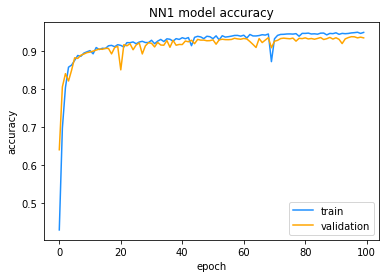

In [65]:
# Plot the accuracy of the fitted model after each epoch.
# An epoch is a full cycle through the training data.
plt.plot(nn_hist.history['accuracy'], color='dodgerblue')
plt.plot(nn_hist.history['val_accuracy'],color='orange')
plt.title('NN1 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')


The plot above confirms that the model has converged on an optimal solution, with both training and validation accuracy increasing rapidly over the first 10 or so epochs and then flattening out after that. Not much further improvement in accuracy is obtained after the first 10 or so epochs.

### Fit a convolutional neural network (CNN)
Next, a convolutional neural network (CNN) is constructed. CNNs are outlined in Section 5.7.1 of Module 5.

The CNN below will use two convolutional layers with a 5x5 filter/kernel.

In [67]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 16, kernel_size = (5,5), 
                 activation ='relu', input_shape = (28,28,1)))
  # Notice from the input_shape = (28,28,1) term above
  # that the CNN takes as input the 28x28 matrix of pixel features
  # rather than the flattened vector of all 784 pixel features. 
cnn_model.add(Conv2D(filters = 16, kernel_size = (5,5), 
                 activation ='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))

cnn_model.add(Flatten())
  # Flatten() converts the matrix outputs from the convolutional layers
  # back into vectors for feeding into the output layer. 
cnn_model.add(Dense(10, activation = 'softmax'))

In [70]:
# Define the regular stochastic gradient descent (SGD) optimiser (without
# momentum, a learning rate of 0.2 and the crossentropy loss function.
# to be used in the fitting of the model.
opt = SGD(learning_rate=0.2, momentum=0.0)
cnn_model.compile(optimizer = opt , loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

epochs = 10
batch_size = 10

# Fit the CNN and capture the error and accuracy rates from the fitted model
# after each epoch.
cnn_hist = cnn_model.fit(train_cnn_x, train_y, batch_size = batch_size,
                         epochs = epochs,
                         validation_data = (validation_cnn_x, validation_y))

Epoch 1/10
2688/2688 [==============================] - 24s 9ms/step - loss: 0.2809 - accuracy: 0.9116 - val_loss: 0.1211 - val_accuracy: 0.9622
Epoch 2/10
2688/2688 [==============================] - 24s 9ms/step - loss: 0.1000 - accuracy: 0.9702 - val_loss: 0.1126 - val_accuracy: 0.9710
Epoch 3/10
2688/2688 [==============================] - 23s 9ms/step - loss: 0.0788 - accuracy: 0.9767 - val_loss: 0.0963 - val_accuracy: 0.9729
Epoch 4/10
2688/2688 [==============================] - 23s 9ms/step - loss: 0.0650 - accuracy: 0.9807 - val_loss: 0.1090 - val_accuracy: 0.9692
Epoch 5/10
2688/2688 [==============================] - 24s 9ms/step - loss: 0.0587 - accuracy: 0.9829 - val_loss: 0.1427 - val_accuracy: 0.9643
Epoch 6/10
2688/2688 [==============================] - 23s 9ms/step - loss: 0.0753 - accuracy: 0.9795 - val_loss: 0.1027 - val_accuracy: 0.9754
Epoch 7/10
2688/2688 [==============================] - 23s 8ms/step - loss: 0.0747 - accuracy: 0.9803 - val_loss: 0.1011 - val_ac

In [69]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                16010     
Total params: 22,842
Trainable params: 22,842
Non-trainable params: 0
_________________________________________________________________


You should note that the CNN takes much longer to fit than the vanilla neural network (NN 1).

### Evaluate CNN

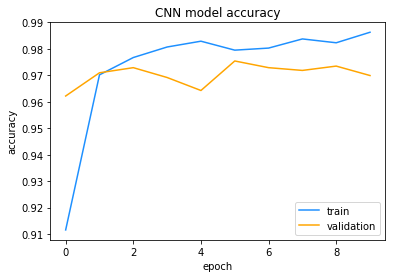

In [71]:
# Plot the accuracy of the CNN against each epoch
# to ensure that the model has converged on an
# optimal solution.
plt.plot(cnn_hist.history['accuracy'],color='dodgerblue')
plt.plot(cnn_hist.history['val_accuracy'],color='orange')
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

The graph of the accuracy suggests that the model may not have converged yet,since the validation accuracy is still volatile after 10 epochs. You can try to obtain a higher accuracy on the validation data by increasing the number of epochs used to train the model.

In [72]:
# Compare the accuracy obtained under the vanilla neural network (NN 1)
# to that obtained under the CNN.
{'CNN':cnn_hist.history['val_accuracy'][-1],
 'NN 1': nn_hist.history['val_accuracy'][-1]}

{'CNN': 0.9699404835700989, 'NN 1': 0.9351190328598022}

The CNN had a higher accuracy after 10 epochs compared to the vanilla neural network after 100 epochs. However, the CNN took substantially more time to train. The final choice of which model to use should take into account the business context and, in particular, the value that the business assigns to a model's accuracy compared to its training efficiency.

### Select the final model

In [73]:
# Select the final model and call it `nn_model_final`.
# In this case, it is assumed that model accuracy is
# more important than model training speed, hence the
# CNN is chosen.
nn_model_final = cnn_model
test_x_final = test_cnn_x

## Observations

### Predict on the test set
Now that a final fitted model has been selected, it can be used to make predictions on the test set.

In [74]:
# Make predictions on the test set.
test_preds = nn_model_final.predict(test_x_final)
# Convert the predictions (y_hat_gk) to class predictions (G(Xi.)).
test_preds_classes = np.argmax(test_preds,axis = 1)
# Convert the encoded responses (i.e. 0s and 1s to a single vector Numpy array
# contained classes 0, 1, 2, ..., 9.
test_y_classes = np.argmax(test_y,axis = 1)

Note that even though the CNN took a long time to train, it is very quick to score (i.e. make predictions based on a set of unseen observations).

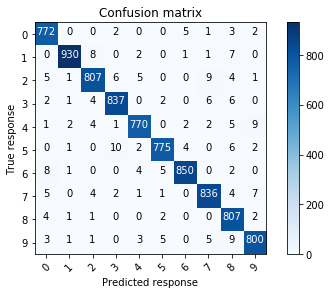

In [75]:
# Use the confusion matrix function defined at the top of the notebook
# to observe the number of observations that have been
# misclassified by the final model.

# Compute the confusion matrix.
confusion_mtx = confusion_matrix(test_y_classes, test_preds_classes) 
# Plot the confusion matrix.
plot_confusion_matrix(confusion_mtx, classes = range(10))

The confusion matrix above shows that the majority of observations have been correctly classified, as previously indicated by the high accuracy obtained from this model.

### Observe example misclassifications
The code below allows you to observe some of the images that were misclassified by the final model. This information might be useful in working out particular types of images that the model found hard to classify correctly, which might inform how to further improve the model. 

1. Actual digit: 4 Predicted digit: 6
2. Actual digit: 5 Predicted digit: 8
3. Actual digit: 2 Predicted digit: 7
4. Actual digit: 9 Predicted digit: 8
5. Actual digit: 9 Predicted digit: 4
6. Actual digit: 7 Predicted digit: 9
7. Actual digit: 4 Predicted digit: 7
8. Actual digit: 0 Predicted digit: 8
9. Actual digit: 5 Predicted digit: 8
10. Actual digit: 7 Predicted digit: 8


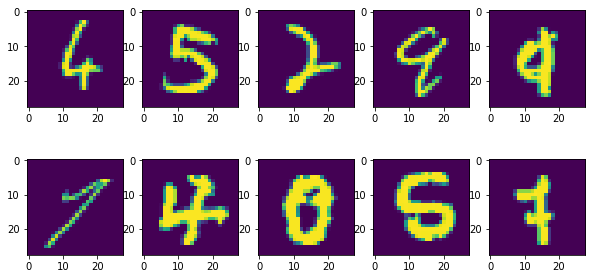

In [76]:
# Create a vector that allows errors to be identified.
errors = test_y_classes - test_preds_classes
error_indexes = np.where(errors != 0)

# Plot the first 10 errors.
fig = plt.figure(figsize=(10,5))
rows = 2
columns = 5
for i in range(0, 10):
    print(str(i+1)+'. Actual digit: ' + str(test_y_classes[error_indexes[0][i]]) +
          ' Predicted digit: ' + str(test_preds_classes[error_indexes[0][i]]))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_x_final[error_indexes[0][i]][:,:,0]);
plt.show()
